In [9]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import os, sys

import plotly.express as px
import plotly
import nbformat

%matplotlib inline

## Functions and Data

In [10]:
# multiply population
# output [0,1]
def sigmoidFunction(z, sigmoid_b, slow_scale):
    fz = []
    for num in z:
        fz.append(1/(1 + math.exp(-(num * slow_scale) + sigmoid_b)))
    return fz

def reach_climax_time (df, col_name):
    return (df[col_name].idxmax(axis=0))

def climax_value(df, col_name):
    climax_id = df[col_name].idxmax(axis=0)
    return (df[col_name].loc[climax_id])

In [11]:
# get the total number of serving population of each clinic

df_com = pd.read_excel("community.xlsx")[["社区名称","常住人口","发热诊室", "x", "y"]]#["地址"]
df_com.fillna(10000, inplace = True)

clinic_name_list = ["金洲社区卫生服务站", "丽景社区卫生服务站", "中天社区卫生服务站", "水都社区卫生服务站"]
clinic_serve_pop_list = [0,0,0,0]
clinic_name_servepop_dic = dict(zip(clinic_name_list, clinic_serve_pop_list))
for i in range(0, len(df_com)):
    clinic_name_servepop_dic[(df_com.iloc[i]["发热诊室"])] += df_com.iloc[i]["常住人口"]


## Simulation

### Normal simulation

In [4]:
def simulationFunc (com_population_list = [43750, 70081, 56015, 68615], clinic_name_list = \
    ["金洲社区卫生服务站", "丽景社区卫生服务站", "中天社区卫生服务站", "水都社区卫生服务站"], \
    clinic_scale_list = [15, 16, 17, 18], recover_time = 7, severe_percent = 0.1, sigmoid_b = 4.6, \
    slow_scale = 0.25, max_sim = 100):

    date_list = list(range(0,max_sim,1))

    total_severe_day_list = [[],[],[],[]]
    clinic_avai_day_list = [[],[],[],[]]
    total_severe_pop = [0,0,0,0]
    total_severe_day_arr = np.zeros((4, len(date_list)))

    #current_clinic_avai = clinic_scale_list #updated everyday

    for day in date_list:
        for i in range(4):
            infected_day_arr = np.asarray(
                sigmoidFunction(date_list, sigmoid_b,
                            slow_scale)) * np.array(com_population_list[i])
            new_infected_list = np.diff(np.insert(infected_day_arr, 0, 0))

            # severe cases
            new_infected_arr = np.asarray(new_infected_list)
            new_severe_arr = new_infected_arr * severe_percent

            total_severe_pop[i] = total_severe_pop[i] + new_severe_arr[day] - clinic_scale_list[i]
            #print(total_severe_pop[i])
            total_severe_day_list[i].append(total_severe_pop[i])
            #print(total_severe_day_list[i])

            if total_severe_pop[i] > 0:
                avai_to_append = 0
            else:
                avai_to_append = total_severe_pop[i] * (-1)
            clinic_avai_day_list[i].append(avai_to_append) ###
            
            total_severe_day_arr[i, day] = np.clip(np.asarray(total_severe_day_list[i][day]),0,com_population_list[i])
            total_severe_day_list[i][day] = np.clip(np.asarray(total_severe_day_list[i][day]),0,com_population_list[i])
            #print(total_severe_day_list[i][day])
            #print("")
            #total_severe_day_list = total_severe_day_arr.tolist() 
            total_severe_pop[i] = total_severe_day_list[i][day] 

            

    df_severe_byday = pd.DataFrame()
    for i in range(4):
        df_severe_byday[clinic_name_list[i]] = total_severe_day_arr[i]

    return df_severe_byday

    

### Super simulation

In [12]:
def superSimulationFunc():
    result = pd.DataFrame()
    com_for_sim_list = ["金洲社区卫生服务站", "丽景社区卫生服务站", "中天社区卫生服务站", "水都社区卫生服务站"]
    outbreak_name_list = ["金山街道金麟社区", "金山街道幸福社区", "金山街道香江社区", "金山街道新筑社区"]
    I_dataframe_list = []
    total_i_dataframe_list = []

    max_sim = 100
    beta = 0.75
    reduced_beta = 0.5
    reduce_intensity = 0.3
    gamma = 0.3
    sigma = 0.2
    total_inflow = 1
    total_new_exposed = 1
    INF = 100000
    reduced_beta_start = max_sim
    reduced_beta_stop = max_sim
    reduced_OD_start = max_sim
    reduced_OD_stop = max_sim
    date = list(range(1,max_sim+1))

    for com_index, com_for_sim in enumerate(com_for_sim_list):
        #print("")
        #print("now going to simulate ", com_for_sim)
        OD_path = com_for_sim + "OD.xlsx"

        df_com_super = pd.read_excel("community.xlsx")[["社区名称","常住人口","发热诊室"]]
        df_com_super.fillna(10000, inplace = True)
        df_com_super = (df_com_super[df_com_super['发热诊室'] == com_for_sim].reset_index()).drop("index",axis=1)

        OD_com_df = pd.read_excel(OD_path)
        OD_com_df.drop(columns=OD_com_df.columns[[0]],inplace=True)
        OD_com_array= OD_com_df.to_numpy()
        OD_sum = np.sum(OD_com_array,axis = 1)
        df_com_super['OD_total'] = OD_sum

        N_k = df_com_super["常住人口"] #!
        N_k_sum=N_k.sum()
        locs_len = N_k.shape[0]
        beta_dist="gamma"

        outbreak_name = outbreak_name_list[com_index]
        sigma_vec = np.repeat(sigma, locs_len) # same incubation-infectious transition rate at each cell
        gamma_vec = np.repeat(gamma, locs_len) # transition rate between Infected and Recovered/Removed



        day = 0
        new_i_list = []
        total_i_list = []
        if beta_dist == "uniform":
                beta_vec = np.repeat(beta,locs_len)
        elif beta_dist == "gamma":
            beta_vec = np.random.gamma(beta/2,2,locs_len)
            zone0_id = df_com_super[df_com_super['社区名称']== outbreak_name].index
            beta_vec[zone0_id] = beta
        else:
            #print("Unknown distribution parameter for beta")
            pass

        zeros = np.repeat(0,locs_len) #!
        matrix = {'S':N_k,'E':zeros,'I':zeros,'R':zeros}
        SEIR = pd.DataFrame(matrix)
        data_infection = df_com_super
        i2 = data_infection[df_com_super["社区名称"] == outbreak_name].index
        zone0_infected = 10
        first_infection = zeros
        first_infection[i2] = 10
        SEIR['S']=SEIR['S']-first_infection
        SEIR['I']=SEIR['I']+first_infection

        Row_sum = SEIR.apply ( lambda x: x. sum (),axis=1)
        SEIR_S=SEIR['S']/Row_sum
        SEIR_E=SEIR['E']/Row_sum
        SEIR_I=SEIR['I']/Row_sum
        SEIR_N=SEIR['R']/Row_sum
        new = {'S':SEIR_S,'E':SEIR_E,'I':SEIR_I,'R':SEIR_N }
        SEIR_n = pd.DataFrame(new)
        SEIR_sim = SEIR
        SEIR_nsim = SEIR_n

        susceptible_pop_norm = SEIR["S"].sum()/N_k_sum
        exposed_pop_norm = SEIR["E"].sum()/N_k_sum
        infected_pop_norm = SEIR["I"].sum()/N_k_sum
        recovered_pop_norm = SEIR["R"].sum()/N_k_sum

        infected_by_day=[]
        infected_by_day.append(SEIR_sim["I"])


        #print("Starting simulation...")
        total_new_exposed = 1
        while (total_new_exposed > 0) & (day < max_sim) :
            day = day + 1 #
            #print("Day: ",day)
            if (reduced_beta_start != INF ): 
                if (day >= reduced_beta_start) & (day < reduced_beta_stop):
                    print("Reducing beta to ",reduced_beta)
                    beta_vec = np.repeat(reduced_beta, locs_len)
            # OD_full_df = pd.read_csv("OD_phone_data.csv",engine='python',encoding='utf-8') #!
            # OD_full_df.drop(columns=OD_full_df.columns[[0]],inplace=True)
            OD_full= OD_com_df.to_numpy()
            OD = OD_full
            OD_reduced = OD * reduce_intensity
            if (reduced_OD_start != INF):
                if (day >= reduced_OD_start) & (day < reduced_OD_stop):
                    print("Reducing traffic...")
                    OD = OD_reduced
            #new E
            SEIR_nsim_I= SEIR_nsim['I'].to_numpy()
            tmp = SEIR_nsim_I.reshape(locs_len,1)
            infected_mat = np.repeat(tmp,locs_len,axis=1)
            OD_infected = OD * infected_mat
            inflow_infected=OD_infected.sum(axis=0)
            total_inflow_infected = inflow_infected.sum()
            #print("Total infected inflow: ", total_inflow_infected)
            new_exposed = beta_vec * SEIR_sim['S'].to_numpy() * inflow_infected / (N_k.to_numpy() + OD.sum(axis=0)) + beta_vec * SEIR_sim['S'].to_numpy() * SEIR_sim['I'].to_numpy() / N_k.to_numpy()
            total_new_exposed = new_exposed.sum()
            #print("New exposed: ", total_new_exposed)

            #new I
            new_infected = sigma_vec * SEIR_sim['E'].to_numpy()
            total_new_infected = new_infected.sum()
            #print("New infected: ", total_new_infected)

            #new R
            new_recovered = gamma_vec * SEIR_sim['I'].to_numpy()
            total_new_recovered = new_recovered.sum()
            #print("New recovered: ", total_new_recovered)

            SEIR['S']=SEIR['S']- new_exposed
            SEIR['E']=SEIR['E']+ new_exposed - new_infected
            SEIR['I']=SEIR['I']+ new_infected - new_recovered
            SEIR['R']=SEIR['R']+ new_recovered

            # recompute the normalized SEIR matrix
            tmp = SEIR_sim.to_numpy().sum(axis=1).reshape(locs_len,1)
            rowSums_SEIR_sim = np.repeat(tmp,4,axis=1)
            #SEIR_nsim = SEIR_sim.to_numpy() / rowSums_SEIR_sim
            S = SEIR_sim['S'].sum()/ N_k_sum
            E = SEIR_sim['E'].sum()/ N_k_sum
            I = SEIR_sim['I'].sum()/ N_k_sum
            R = SEIR_sim['R'].sum()/ N_k_sum
            #print("S:", S, "E:", E,"I:", I,"R:", R,"Total:", N_k_sum)

            new_i_list.append(total_new_infected)
            total_i_list.append(SEIR_sim['I'].sum())

            susceptible_pop_norm=[susceptible_pop_norm,S]
            exposed_pop_norm=[exposed_pop_norm,E]
            infected_pop_norm=[infected_pop_norm,I]
            reovered_pop_norm=[recovered_pop_norm,R]
            infected_by_day.append(SEIR_sim["I"])



        # print("len of result: ", str(len(result)))
        # print("len of total i list: ", str(total_i_list))
        result[com_for_sim] = total_i_list



    return result


<AxesSubplot: >

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  func(*args, **kwargs)
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 27954 (\N{CJK UNIFIED IDEOGRAPH-6D32}) missing from current font.
  func(*args, **kwargs)
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 31038 (\N{CJK UNIFIED IDEOGRAPH-793E}) missing from current font.
  func(*args, **kwargs)
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  func(*args, **kwargs)
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 21355 (\N{CJK UNIFIED IDEOGRAPH-536B}) missing from current font.
  func(*args, **kwargs)
C:\Users\admin\

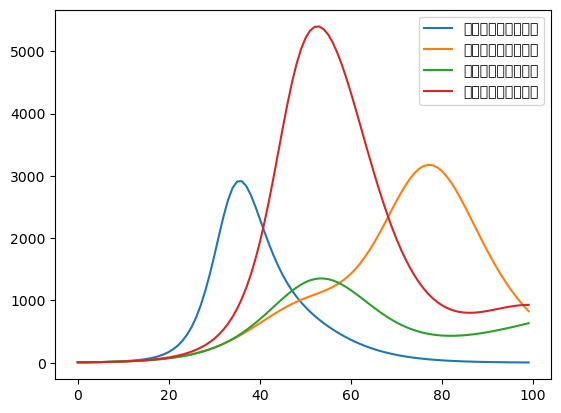

In [15]:
df_severe_byday0 = superSimulationFunc()
df_severe_byday0.plot()

## Plotly

### Animation

In [16]:
# df_T = pd.DataFrame(df_severe_byday.values.T,columns=index_row,index=index_colums)
df_severe_byday = superSimulationFunc ()
transformed_df = pd.DataFrame({"day": [], "severe cases": [], "name": []})
clinic_name_list = ["金洲社区卫生服务站", "丽景社区卫生服务站", "中天社区卫生服务站", "水都社区卫生服务站"]

for i in range (len(df_severe_byday)):
    
    one_line = df_severe_byday.iloc[i]
    one_column_list = (df_severe_byday.iloc[i].T).tolist()
    one_day_list = (np.ones(4,int)*i).tolist()
    one_df = pd.DataFrame({"day": one_day_list, "severe cases": one_column_list, "name": clinic_name_list})
    transformed_df = pd.concat([transformed_df,one_df], ignore_index=True)

px.bar(transformed_df,x="name",y="severe cases",animation_frame = 'day', range_y = [0, 8000], color = "name", color_discrete_sequence=px.colors.qualitative.Antique)

KeyboardInterrupt: 

### Line plot

In [17]:
df_severe_byday = superSimulationFunc ()
date_list = [i for i in range (len(df_severe_byday))]
df_severe_byday["day"] = date_list
fig = px.line(transformed_df, x="day", y = "severe cases", color = "name", color_discrete_sequence=px.colors.qualitative.Antique)
plotly.offline.plot(fig, filename="fig.html")

ValueError: Length of values (100) does not match length of index (15)

## Seaborn

In [ ]:
df_severe_byday = simulationFunc (max_sim = 200)
df_severe_byday.head()

,金洲社区卫生服务站,丽景社区卫生服务站,中天社区卫生服务站,水都社区卫生服务站
0,28.539133,53.743223,38.745018,50.284289
1,25.747779,57.299659,37.376271,51.431631
2,26.323435,66.249546,40.318450,57.859599
3,31.159007,82.023186,48.714784,70.968578
4,41.361847,106.394391,63.983060,92.495271


Generating pictures to the folder pic_for_video3...199/200

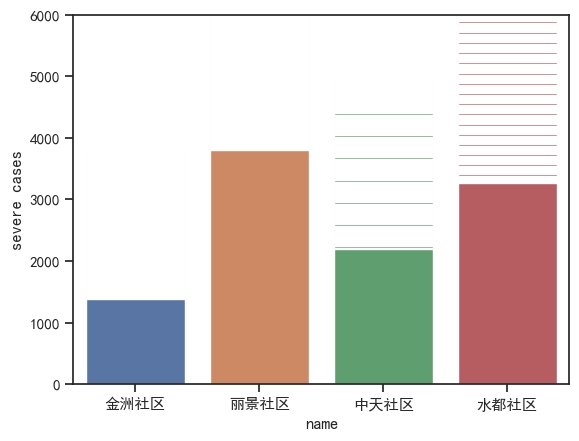

In [ ]:
clinic_name_list_short = ["金洲社区", "丽景社区", "中天社区", "水都社区"]


for i in range(len(df_severe_byday)):
    #print(i)
    folder = "pic_for_video3"
    save_path = folder + '/' + str(i) + '.jpg'
    print('\r'+"Generating pictures to the folder " + folder + "..." + str(i)+'/'+str(len(df_severe_byday)), end='')
    one_df = pd.DataFrame()
    one_df["name"] = clinic_name_list_short
    one_df["severe cases"] = df_severe_byday.iloc[i].tolist()

    rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
    sns.set(context='notebook', style='ticks', rc=rc)
    bar_plot = sns.barplot(x="name", y="severe cases", data=one_df)
    bar_plot.set_ylim(0,6000)

    
    # cv.imwrite(save_path, bar_plot, [cv.IMWRITE_PNG_COMPRESSION, 0])

    fig_tosave = bar_plot.get_figure()
    fig_tosave.savefig(save_path, dpi = 400)

In [ ]:
read_path = 'pic_for_video/' + str(0) + '.png'
frame = cv.imread(read_path)
print(frame.shape)

(1920, 2560, 3)


In [ ]:
fourcc = cv.VideoWriter_fourcc(*'mp4v')
save_video_folder = "video_generated"
out = cv.VideoWriter(save_video_folder + '/testwrite.mp4',fourcc, 20.0, (2560,1920),True)

for i in range(len(df_severe_byday)):
    print('\r'+"Generating a video to the folder " + save_video_folder + "..." + str(i)+'/'+str(len(df_severe_byday)), end='')
    read_path = 'pic_for_video3/' + str(i) + '.jpg'
    frame = cv.imread(read_path)
    out.write(frame)
    #print("i: ",i)

out.release()


Generating pictures to the folder video_generated...199/200

## Compute weights

In [8]:
df_severe_byday = superSimulationFunc()

reach_climax_time_list = []
climax_value_list = []
clinic_name_list = ["金洲社区卫生服务站", "丽景社区卫生服务站", "中天社区卫生服务站", "水都社区卫生服务站"]

for name in clinic_name_list:
    reach_climax_time_list.append(reach_climax_time(df_severe_byday, name))
    climax_value_list.append(climax_value(df_severe_byday, name))

clinic_name_climax_time_dic = dict(zip(clinic_name_list, reach_climax_time_list))
clinic_name_climax_value_dic = dict(zip(clinic_name_list, climax_value_list))

df_all = pd.read_excel("community.xlsx")[["社区名称","常住人口","发热诊室", "x", "y"]]
df_all["达峰时间"] = np.zeros(len(df_all))
df_all["峰值"] = np.zeros(len(df_all))

for clinic in clinic_name_list:
    df_all.loc[df_all['发热诊室']==clinic,"达峰时间"] = clinic_name_climax_time_dic[clinic]
    df_all.loc[df_all['发热诊室']==clinic,"峰值"] = clinic_name_climax_value_dic[clinic]

temp = df_all["峰值"]/df_all["达峰时间"]
df_all["w"] = temp / (temp.max())

df_all.to_excel("community2.xlsx")

ValueError: Length of values (18) does not match length of index (13)

In [ ]:
df_all

,社区名称,常住人口,发热诊室,x,y,达峰时间,峰值,w
0,金山街道金洲社区,8500.0,金洲社区卫生服务站,1154,283,43.0,1978.072000,0.241037
1,金山街道幸福社区,7850.0,丽景社区卫生服务站,801,945,39.0,7443.125472,1.000000
2,金山街道六江道社区,6900.0,中天社区卫生服务站,432,980,51.0,4934.479471,0.506968
3,金山街道金环社区,10832.0,金洲社区卫生服务站,1303,256,43.0,1978.072000,0.241037
4,金山街道鑫龙社区,9000.0,丽景社区卫生服务站,704,479,39.0,7443.125472,1.000000
5,金山街道金河社区,6500.0,金洲社区卫生服务站,887,286,43.0,1978.072000,0.241037
6,金山街道香江社区,13620.0,中天社区卫生服务站,163,569,51.0,4934.479471,0.506968
7,金山街道建中社区,24120.0,丽景社区卫生服务站,577,718,39.0,7443.125472,1.000000
8,金山街道新筑社区,24000.0,水都社区卫生服务站,1065,816,61.0,2731.238216,0.234606
9,金山街道中天社区,13563.0,中天社区卫生服务站,381,826,51.0,4934.479471,0.506968


## Write the data into excel

In [ ]:
output_excel = pd.read_excel("community.xlsx")
output_excel["w"] = df_all["w"]
output_excel.to_excel("community.xlsx")